# K-Means algorithm implementation from scratch

## Intro to K-Means

Despite being behind supervised learning in popularity unsupervised learning has many applications nowadays even if we don't realize it. For example we often perform PCA or SVD to reduce dimensions, we put Embeddings Layers in Neural networks mechanically, we have clustering, hierarchical clustering analysis(HCA) and of course the K-Means clustering which is the main topic of this report.  These algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points. 

Unlike HCA we need to have very deep understanding of the data because we are going to use predefined number K. It all depends on this number, if we mess this up, there is no coming back from that.It might be easy to eyeball the appropriate number K in 2 or 3 dimensional space but this is not the case if we have large and wide dataset. There are methods that come in help in situations like these - check the so-called [Elbow Method](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/), a very popular methodology for defining the right K.


## Goal and Workflow

Here we'll focus on the lowest level of K-Means - its raw implementation. We'll not bother with optimizing, building pipelines or even making it super reusable and abstract, applying OOP paradigm for example. The goal is to get familiar with the algorithm and the logic and mathematics behind with simple, non-fancy implementation in raw python.

We'll start with Scikit Learn to generate data(clusters more precisely or blobs as they are named), use their KMeans class to separate the clusters, perform some EDA and Hypothesis testing and then we'll try to repeat the results with our own custom implementation of the famous algorithm.

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('grayscale')

In [3]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [4]:
import scipy.stats as st

## The data we'll be working with + EDA

Scikit Learn has got a very nice generator 'make_blobs'. It basically generates data in clusters according to the parameters you set. Here we'll create 3 relatively easy to separate clusters but not super easy like in a book example. 300 samples, 100 for each label with standard deviation of 0.6 should be good enough to visually separate and be challenging at the same time.

Let's see what we've got.

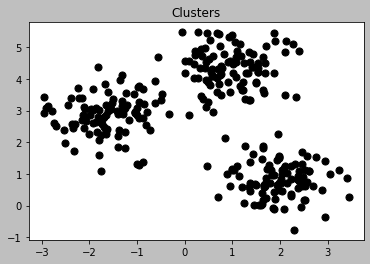

In [5]:
x, y = make_blobs(n_samples=300, centers=3,
                       cluster_std=0.60, random_state=0)
plt.scatter(x[:, 0], x[:, 1], s=50)
plt.title('Clusters');

"Make_blobs" returns two structures - The generated samples and integer labels for cluster membership of each sample.

Let's take a look at the columns of 'x', in this case there are only 2 because we work in 2d.

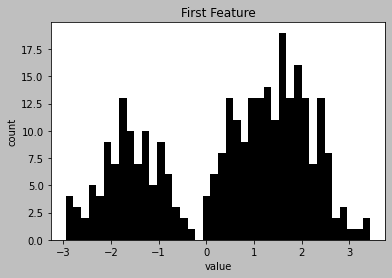

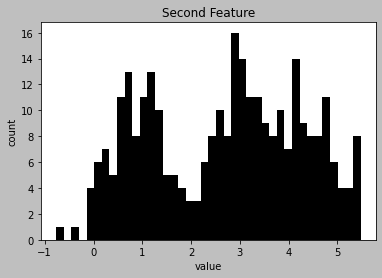

In [6]:
plt.hist(x[:,:1], bins=40)
plt.title('First Feature')
plt.xlabel('value')
plt.ylabel('count')
plt.show()
plt.hist(x[:,1:], bins=40)
plt.title('Second Feature')
plt.xlabel('value')
plt.ylabel('count')
plt.show()

On the first histogram we see that the cluster that is on the left is easily separatable from the other two. They mix up a bit so this should be the huge difficulty for the algorithm that we'll try to build.

On second histogram the distribution is almost perfectly threemodal because they differ significantly based on their Y values.

One last thing we can check graphically before the implementation is the distribution of the target values. Hopefully we won't have to take any actions, they should be equally represented. 

In [7]:
colors = ['black', 'purple', 'darkblue']

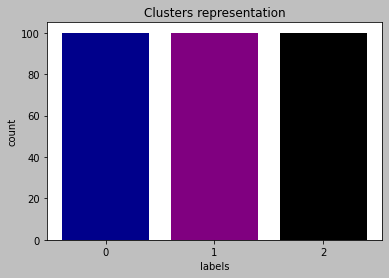

In [8]:
# Use pandas series data structure to group by value
grouped_target = pd.Series(y).value_counts()
plt.bar(grouped_target.index, grouped_target, color=colors)
plt.xticks(range(0, 3))
plt.xlabel('labels')
plt.ylabel('count')
plt.title('Clusters representation');

'Surprisingly' everything is perfect. These guys in Scikit Learn seem to know what they are doing xD. 

Since we are going to implement this model let's check how the Scikit Learn will describe the data first. It's always good thing to have something to compare with.

## Scikit Learn KMeans

Using Scikit Learn Models is extremely easy. You only use the class method 'fit' to train the data and 'predict' to test and you are done. Of course there is an EDA, which we conduncted, feature engineering, often some sort of dimensionality reduction(PCA, SVD) and definitely hyperparameter tuning, but in this case we don't need that so it's straightforward.

In [9]:
# We are looking for three clusters remember

kmeans = KMeans(n_clusters=3)
kmeans.fit(x)
prediction = kmeans.predict(x)

Now let's check the results.

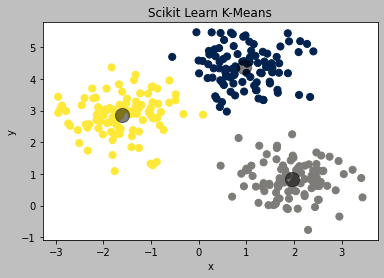

In [10]:
plt.scatter(x[:, 0], x[:, 1], c=prediction, s=50, cmap='cividis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scikit Learn K-Means');

Looks pretty good. Seems like they all've been classified correctly. 

**Note. Here we used the term 'classified' but K-Means usually don't classify labels, it finds clusters. Here we just check the validity of our own implementation.**

The most common metric used for classification problems and probably the easiest one is accuracy:

Accuracy = $Correct \over sum(Total)$ 


or if you have confusion matrix and want to calculate Accuracy = $True Positives + True Negatives \over sum(Total)$

In this case we cannot use accuracy score freely because even though KMeans asssignes labels to its prediction, these labels might differ from the original ones. But we can use the moment to make some hypothesis testing.

## Hypothesis testing

- Null hypothesis:  there is nothing interesting in the data, the differences are random.

- Alternative hypothesis: the three clusters are different.

$\alpha$ critical = 2%

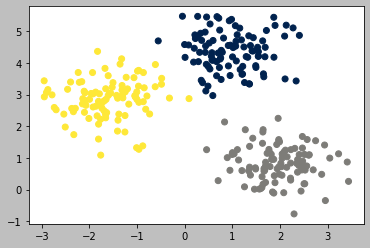

In [11]:
# Again we use Pandas to ease the process

df = pd.DataFrame(x, columns =['feature1', 'feature2'])
df['label'] = prediction
plt.scatter(df['feature1'], df['feature2'], c=df.label, cmap='cividis');

So everything is good. Now the question is what type of test to perform. The feature1 and feature2 are not independent so we will perform related test. We might do T-test or Anova since we have two columns. Let's do the latter one.

In [12]:
# Filter by labels

zeroes = (df[df['label'] == 0])
ones = df[df['label'] == 1]
twos = df[df['label'] == 2]

In [13]:
print(st.f_oneway(zeroes['feature1'], ones['feature1']).pvalue)
print(st.f_oneway(twos['feature1'], ones['feature1']).pvalue)
print(st.f_oneway(twos['feature1'], zeroes['feature1']).pvalue)

6.006745181016222e-25
1.6557027519718475e-99
1.7319665897078496e-74


In [14]:
print(st.f_oneway(zeroes['feature2'], ones['feature2']).pvalue)
print(st.f_oneway(twos['feature2'], ones['feature2']).pvalue)
print(st.f_oneway(twos['feature2'], zeroes['feature2']).pvalue)

1.0046537035701446e-102
6.784570778154981e-62
3.5417777976486205e-42


It was pretty obvious by the graphics we made but now we scientifically rejected the null hypothesis. These features differ significantly and that's not based on chance.

## Implementation of KMeans from scratch

Now we need to reproduce the same result(or magic so to say) as Scikit Learn class. Let's start by creating a new pandas Dataframe that we'll call "df_test".

In [15]:
cols = {'feature1': df['feature1'], 'feature2': df['feature2'], 'label': np.random.randint(0, 3, 300)}

In [16]:
df_test = pd.DataFrame(data=cols)
df_test.sample(5)

,feature1,feature2,label
222,2.470191,1.314513,1
136,-1.554326,3.050187,1
119,2.455097,0.621232,1
16,1.217675,3.892901,2
281,1.663822,0.663092,0


And visualize what we've got.

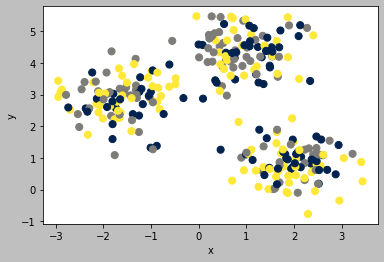

In [17]:
plt.scatter(x[:, 0], x[:, 1], c=df_test['label'], s=50, cmap='cividis')
plt.xlabel('x')
plt.ylabel('y');

So we got the two feature tables from above and we randomly labeled the data so we can visualize the randomness. :D This mess should prove it. Now let's get to work.

**Note! We'll use and rewrite the 'x' variable and we'll create new dataframes for the next tests. We'll use the hyperparameter 'c' with the new dataframes columns 'label' to visualize the work of our algorithm when it's done with iterations.**

First step: decide of the K - since we are trying to fit the data x from above, the K is going to be equal to 3.

Second we need to initialize random centroids. Let's be within  the range of min-max values of the data.

In [18]:
min_x = np.min(x)
max_x = np.max(x)

Initialize random centroids

In [19]:
centroid1 = list((np.random.uniform(min_x, max_x), np.random.uniform(min_x, max_x)))
centroid2 = list((np.random.uniform(min_x, max_x), np.random.uniform(min_x, max_x)))
centroid3 = list((np.random.uniform(min_x, max_x), np.random.uniform(min_x, max_x)))

Let's plot the centroids.

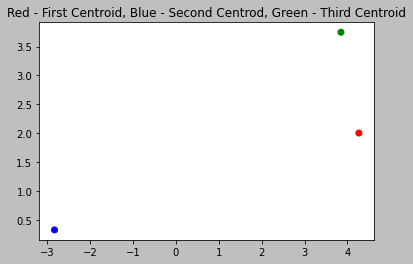

In [20]:
plt.scatter([centroid1[0], centroid2[0],centroid3[0]], [centroid1[1], centroid2[1],centroid3[1]], 
            c = ['red', 'blue', 'green'])
plt.title('Red - First Centroid, Blue - Second Centrod, Green - Third Centroid')
plt.show()

Now we need to start assigning our points to these clusters. We stop when there is no change in any of the points. We'll use euclidean distance to label the points.


d = $\sqrt{(x2 - x1)^2 + (y2-y2)^2}$


where **(x1, y1)** - are the coordinates of the first point 


and **(x2, y2)** - are the coordinates of the second point 

In [21]:
# With this function we update the centroids at the end of every iteration

def update_centroids(df_t):
    
    """
    df_t: dataframe with new coordinates of centroids
    """
    
    centroid1[0] = df_t.iloc[0]['feature1']
    centroid1[1] = df_t.iloc[0]['feature2']
    centroid2[0] = df_t.iloc[1]['feature1']
    centroid2[1] = df_t.iloc[1]['feature2']
    centroid3[0] = df_t.iloc[2]['feature1']
    centroid3[1] = df_t.iloc[2]['feature2']
    

In [22]:
def custom_kmean_from_scratch(n, dff):

    """
    1) n: Array/Series with pair of coordinates,
    2) dff: DataFrame object with columns 'feature1', 'feature2' and 'label',
    """
        

    """
    Iterates until we stop it manually. In this case:
    When we make a full iteration without a single change.
    """
    while True:
        changes = 0
        
        """
        for each point measures the distance and assignes to 
        the closest centroid
        """
        for current_point in range(len(n)):
            x1 = n[current_point][0]
            y1 = n[current_point][1]
            distance1 = np.sqrt((centroid1[0] - x1)**2 + (centroid1[1] - y1) **2)
            distance2 = np.sqrt((centroid2[0] - x1)**2 + (centroid2[1] - y1) **2)
            distance3 = np.sqrt((centroid3[0] - x1)**2 + (centroid3[1] - y1) **2)
            
            """
            If we are closer now to another centroid
            we record the change, else - we move on as it is.
            """
            
            if distance1 < distance2 and distance1 < distance3:
                if dff['label'][current_point] == 0:
                    continue
                dff['label'][current_point] = 0
                changes += 1
                continue
            if distance2 < distance1 and distance2 < distance3:
                if dff['label'][current_point] == 1:
                    continue
                dff['label'][current_point] = 1
                changes += 1
                continue
            if dff['label'][current_point] == 2:
                continue
            dff['label'][current_point] = 2
            changes += 1

        
        """
        If some of the centroids are initialized far from all
        the points then there we'll be no assigned values so here we 
        make its new coordinates random within min-max range again with some pandas magic
        """
        
        if dff.groupby('label').mean().shape[0] != 3:
            temp_df = pd.DataFrame()
            d = {'feature1': np.random.uniform(min_x, max_x, 1), 'feature2': np.random.uniform(min_x, max_x, 1)}
            ddd = pd.DataFrame(data=d)
            if 2 not in dff.groupby('label').mean().index:
                temp = dff.groupby('label').mean().append(ddd)
                temp_df = temp
                del temp
            else:
                temp = dff.groupby('label').mean().append(ddd).sort_index()
                temp_df = temp
                del temp
        else:
            temp_df = dff.groupby('label').mean()
            
        """
        Updates centroids with the new
        coordinates(mean coordinates of all values under the particular cluster)
        and stops if it hasn't been any new change
        """    
        update_centroids(temp_df)
        
        if changes == 0:
            break
            
            
custom_kmean_from_scratch(x, df_test)

The algorithm is actually quite simple. Once we've assigned the centroids we start measuring distances. We iterate through each point and assign it to the nearest centroid. Once we've concluded the loop, we group by the newly formed labels and measure the mean of the coordinates. These are the new coordinates of our centroids. They cannot remain stationary. Now with the new centroids we measure again. 

Once we iterate without a single change in any point we are done. 

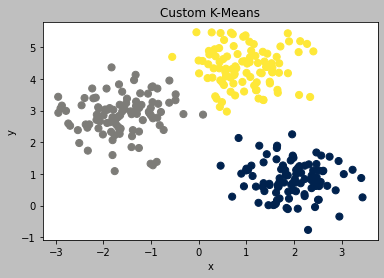

In [23]:
plt.scatter(x[:, 0], x[:, 1], c=df_test['label'], s=50, cmap='cividis')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Custom K-Means');

Cool we did it. Now let's try some other clustering problems and distributions.

## More tests

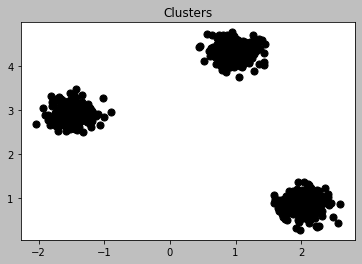

In [24]:
x, y = make_blobs(n_samples=600, centers=3,
                       cluster_std=0.2, random_state=0)
plt.scatter(x[:, 0], x[:, 1], s=50)
plt.title('Clusters');

Recreating the mess.

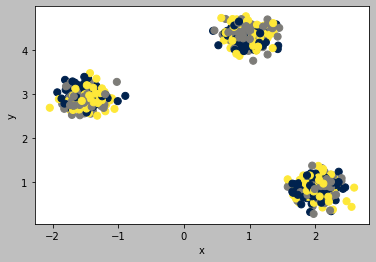

In [25]:
cols2 = {'feature1': x[:,:1].ravel(), 'feature2': x[:,1:].ravel(), 'label': np.random.randint(0, 3, 600)}
df_test2 = pd.DataFrame(data=cols2)
plt.scatter( x[:,:1].ravel(), x[:,1:].ravel(), c=df_test2['label'], s=50, cmap='cividis')
plt.xlabel('x')
plt.ylabel('y');

And the magic.

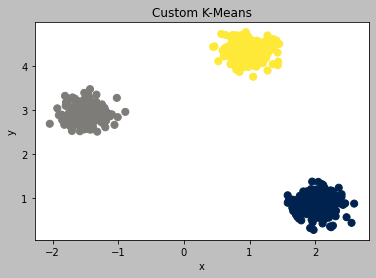

In [26]:
custom_kmean_from_scratch(x, df_test2)
plt.scatter( x[:,:1].ravel(), x[:,1:].ravel(), c=df_test2['label'], s=50, cmap='cividis')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Custom K-Means');

This one was extremely easy. Let's try something harder.

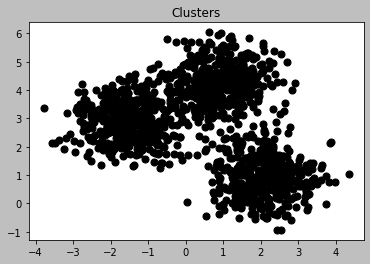

In [27]:
x, y = make_blobs(n_samples=1342, centers=3,
                       cluster_std=0.72, random_state=0)
plt.scatter(x[:, 0], x[:, 1], s=50)
plt.title('Clusters');

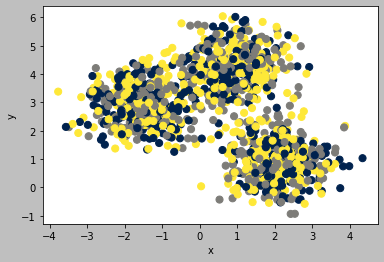

In [28]:
cols3 = {'feature1': x[:,:1].ravel(), 'feature2': x[:,1:].ravel(), 'label': np.random.randint(0, 3, 1342)}
df_test3 = pd.DataFrame(data=cols3)
plt.scatter( x[:,:1].ravel(), x[:,1:].ravel(), c=df_test3['label'], s=50, cmap='cividis')
plt.xlabel('x')
plt.ylabel('y');

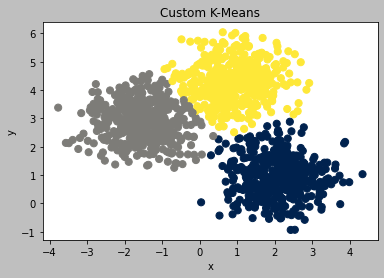

In [29]:
custom_kmean_from_scratch(x, df_test3)
plt.scatter( x[:,:1].ravel(), x[:,1:].ravel(), c=df_test3['label'], s=50, cmap='cividis')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Custom K-Means');

Pretty good clustering.

## Time Measure vs Scikit Learn

Let's make an efficency test now and compare where we are standing compared to the Scikit Learn Class. 10k points should be challenging enough.

In [30]:
import time

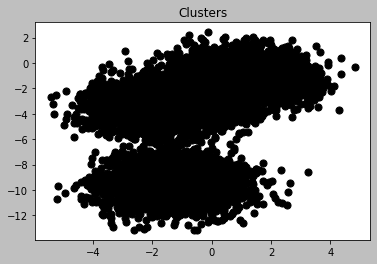

In [31]:
x, y = make_blobs(n_samples=10000, centers=3,
                       cluster_std=1.1, random_state=2)
plt.scatter(x[:, 0], x[:, 1], s=50)
plt.title('Clusters');

In [32]:
start = time.time()
kmeans = KMeans(n_clusters=3)
kmeans.fit(x)
prediction = kmeans.predict(x)
end = time.time()
scikit_time = end - start

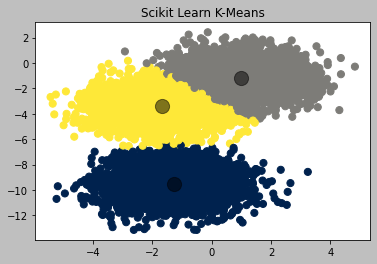

In [33]:
plt.scatter(x[:, 0], x[:, 1], c=prediction, s=50, cmap='cividis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.title('Scikit Learn K-Means');

Our turn.

In [34]:
cols4 = {'feature1': x[:,:1].ravel(), 'feature2': x[:,1:].ravel(), 'label': np.random.randint(0, 3, 10000)}
df_test4 = pd.DataFrame(data=cols4)

In [35]:
start = time.time()
custom_kmean_from_scratch(x, df_test4)
end = time.time()
custom_kmeans_time = end - start

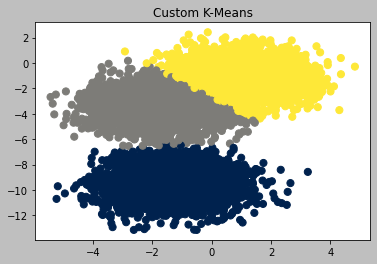

In [36]:
plt.scatter( x[:,:1].ravel(), x[:,1:].ravel(), c=df_test4['label'], s=50, cmap='cividis')
plt.title('Custom K-Means');

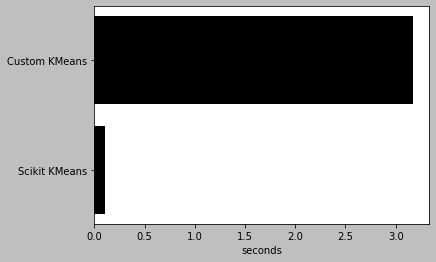

In [37]:
plt.barh(['Scikit KMeans', 'Custom KMeans'], [scikit_time, custom_kmeans_time])
plt.xlabel('seconds');

It took awhile but at least we are correct. :D As you can see a famous library like Scikit Learn has highly optimized models that are used in productions by many people. Not surprise we lost that one.

## Conclusion

So we managed to create a KMeans for clustering these blobs-like distributions. As you can probably know already, this will fail miserably with other distribution and shapes(if you are lucky to see them in 2 or 3d). Thankfully there are other solutions that you can check [here](https://scikit-learn.org/stable/modules/clustering.html). 

Even though our model is working it is highly unoptimized and slow compared to some other implementations. Here I also display with exact 3 clusters every time but it's not hard to make it work with whatever K number you want.

## Sources:


1) Scikit Learn - [official site](https://scikit-learn.org/stable/)

2) KMeans implementation theory - [medium article](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a)

3) Different clustering algorithms depending on the distributions - [click](https://scikit-learn.org/stable/modules/clustering.html)

4) Jake Van Der Plas - Data Science Handbook, k-Means Clustering Chapter.